In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pickle

2025-10-01 21:47:11.739020: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-01 21:47:11.795227: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%reload_ext autoreload
%autoreload 2

from spin_system import SpinSystem
from spin_system import interactions, plots

In [3]:
retry = 1
while retry < 3:
    try:
        lattice_dim = 2
        sweep_length = int(np.round(10000/retry))
        lattice_length = 32
        lattice_replicas = 32
        betas = tf.sort(
            tf.concat(
                [
                    tf.linspace(0.01, 0.9, 10), 
                    tf.linspace(2.1, 3, 10),
                    tf.linspace(0.91, 2.0, 20)
                ], 
                axis = 0
            )
        )

        interaction_matrix = interactions.curie_weiss(lattice_dim, lattice_length)
        spin_system = SpinSystem(
            lattice_dim=lattice_dim,
            lattice_length=lattice_length,
            lattice_replicas=lattice_replicas,
            interaction_matrix=interaction_matrix,
            model="spherical",
            initial_magnetization=0.5,
        )

        # Run the multi-temperature sweep
        results = spin_system.multi_temperature_sweep(
                betas=betas,
                num_disturb=tf.constant(1, dtype=tf.int32),
                theta_max=2*np.pi,
                sweep_length=sweep_length,
                restore_initial_state=False,
                track_spins=False,
                track_energy=True,
                track_magnetization=True
        )

        # Convert tensors to numpy arrays for saving
        results_to_save = {k: v.numpy() if isinstance(v, tf.Tensor) else v for k, v in results.items()}

        # Save the dict
        with open(f'../data/results_spherical_2d_mean_field_{sweep_length}_steps_refeed_state.pkl', 'wb') as f:
            pickle.dump(results_to_save, f)

        break

    except Exception as e:
        print(f"Error: {e}")
        retry += 1

I0000 00:00:1759366037.680354   57060 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


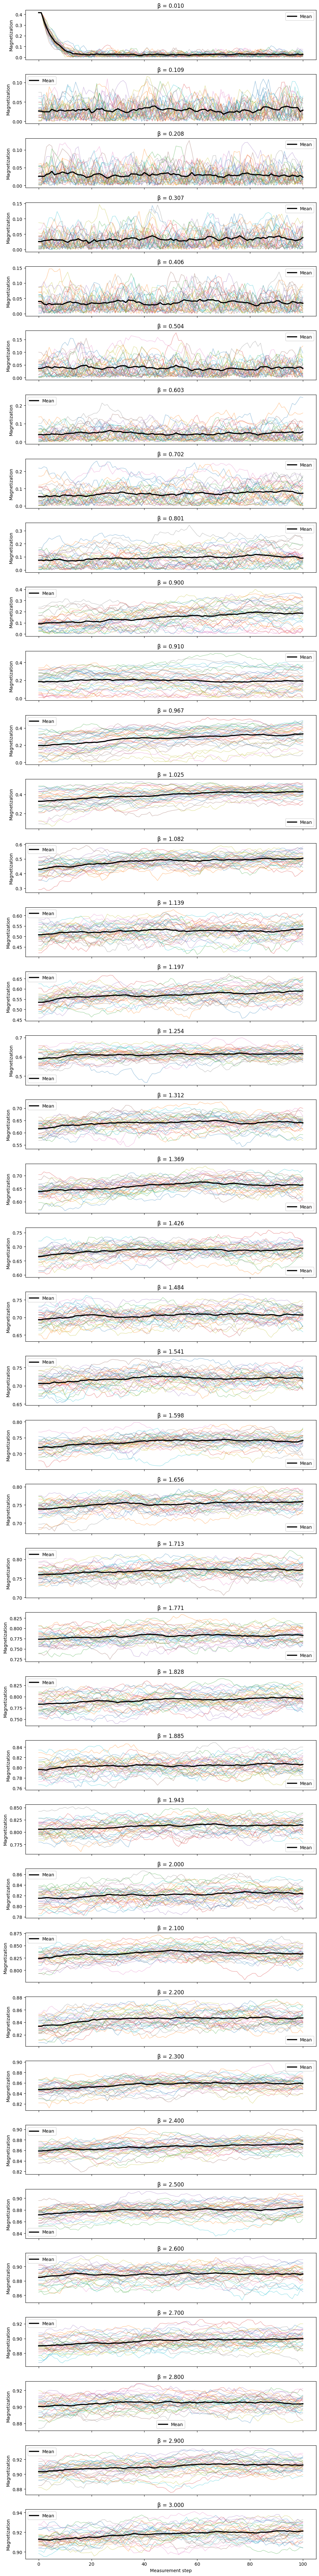

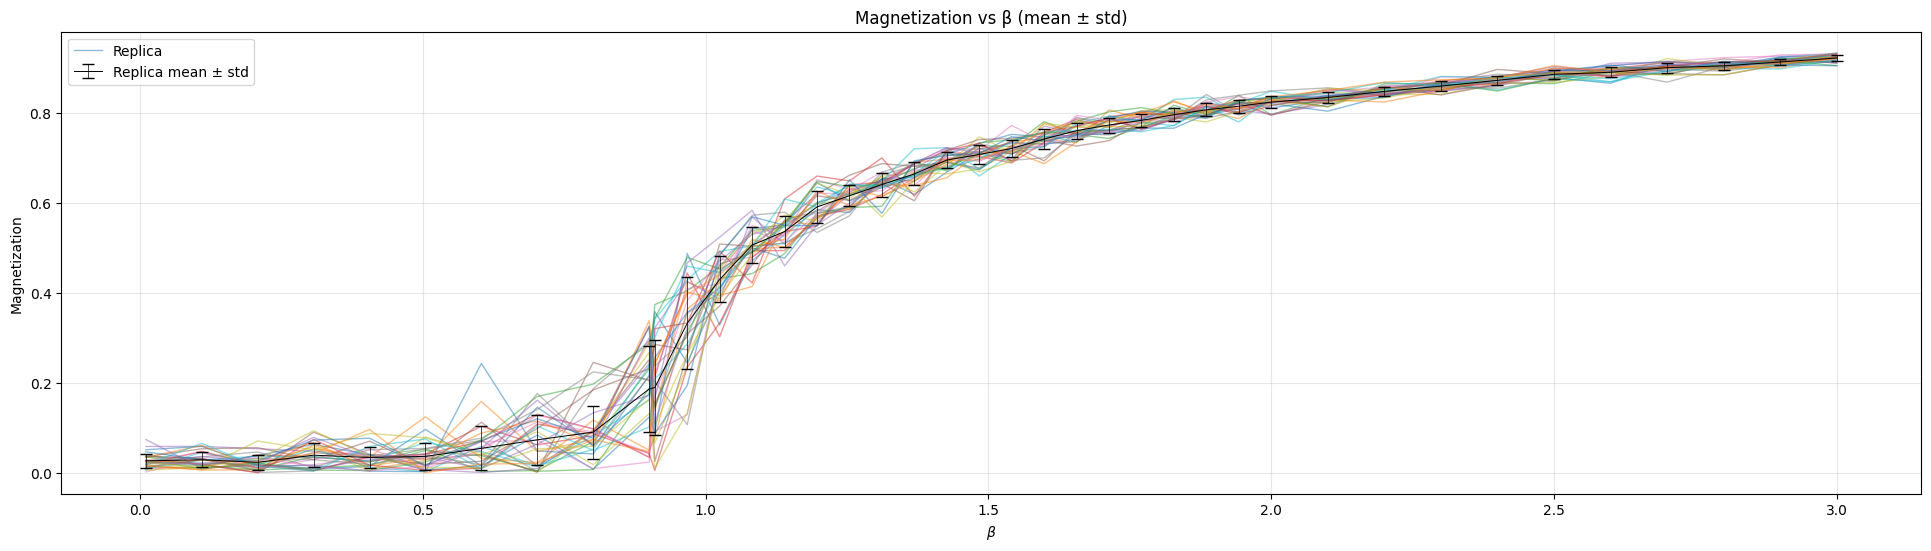

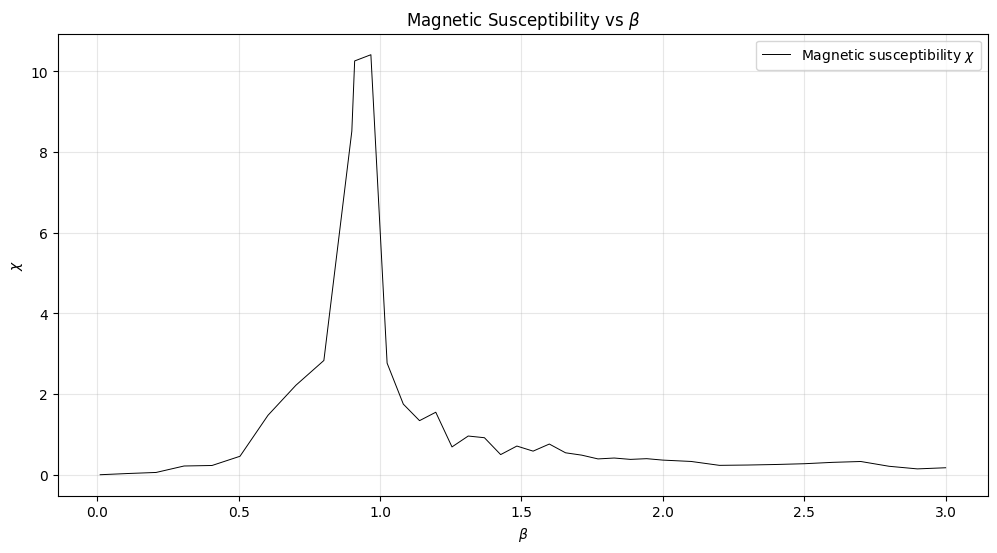

In [9]:
# Collect betas and corresponding magnetization arrays
betas_sorted = results['betas']
magnetization_data = abs(results["magnetization_evolution"].numpy())

n_betas = len(betas_sorted)
steps   = magnetization_data[0].shape[0]
replicas = magnetization_data[0].shape[1]

# Plot evolution for each beta
fig, axes = plt.subplots(nrows=n_betas, ncols=1, figsize=(10, 2*n_betas), sharex=True)

if n_betas == 1:
    axes = [axes]  # ensure iterable if only 1 beta

for idx, beta in enumerate(betas_sorted):
    ax = axes[idx]
    magnetization_beta = magnetization_data[idx]  # shape (steps, replicas)

    # plot all replicas
    for r in range(replicas):
        ax.plot(range(steps), magnetization_beta[:, r], alpha=0.4, lw=1)

    # plot mean across replicas
    mean_magnetization = magnetization_beta.mean(axis=1)
    ax.plot(range(steps), mean_magnetization, color="black", lw=2.5, label="Mean")

    ax.set_title(f"β = {beta:.3f}")
    ax.set_ylabel("Magnetization")
    ax.legend()

axes[-1].set_xlabel("Measurement step")
plt.tight_layout()
plt.show()


# --- Final magnetization (last step) ---
final_magnetization_replicas = np.array([m[-1, :] for m in magnetization_data])  # (n_betas, replicas)

# Compute mean and std across replicas
final_magnetization_mean = final_magnetization_replicas.mean(axis=1)
final_magnetization_std  = final_magnetization_replicas.std(axis=1)

plt.figure(figsize=(24, 6))

# Plot each replica (faded for readability)
for r in range(replicas):
    plt.plot(
        betas_sorted,
        final_magnetization_replicas[:, r],
        lw=1,
        alpha=0.5,
        label="Replica" if r == 0 else None,
    )

# Overlay average across replicas in black with error bars
plt.errorbar(
    betas_sorted,
    final_magnetization_mean,
    yerr=final_magnetization_std,
    color="black",
    elinewidth=0.5,
    capsize=4,
    lw=0.7,
    label="Replica mean ± std"
)

plt.xlabel(r"$\beta$")
plt.ylabel("Magnetization")
plt.title("Magnetization vs β (mean ± std)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# --- Susceptibility ---
N = lattice_length ** lattice_dim  # total number of spins

# Variance across replicas
final_magnetization_var = final_magnetization_replicas.var(axis=1)

# Susceptibility (χ = β N Var(M))
susceptibility = np.array(betas_sorted) * N * final_magnetization_var

plt.figure(figsize=(12, 6))
plt.plot(
    betas_sorted,
    susceptibility,
    lw=0.7,
    color="black",
    label=r"Magnetic susceptibility $\chi$",
)

plt.xlabel(r"$\beta$")
plt.ylabel(r"$\chi$")
plt.title(r"Magnetic Susceptibility vs $\beta$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
